In [ ]:
#clone forked IndoNLU Github
!git clone 'https://github.com/billiechristian/indonlu'

In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import timeit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, RepeatedKFold, cross_val_predict
from xgboost import XGBClassifier

# Viz
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
sns.set(style='ticks', palette='Set2')

# NLP
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import emoji

#Model IndoBERT
import random
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader

ModuleNotFoundError: ignored

# Exploratory Data Analysis

In [ ]:
# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
display(train.head(), test.head())

,review_id,review_text,category
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0


,review_id,review_text
0,7302180ac7160f04a405d8aa7bd6beb8,"Kasur rusak, punggung saya sakit, kasurnya ga ..."
1,3184c670e170f565c7522eb76a320ba1,gerah
2,e33abf6bb5d5a9a77c339043b1725dc8,"tempat ridur atas bawah.. ac nya pararel, tdk ..."
3,061d388950340070a6ac03fabc9027b0,"ac kurang dingin, tidak ada snack sperti di foto"
4,e62d87c348674b6c06856964f3ab16b8,Lumayan untuk guest house dengan standart harg...


In [ ]:
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (14856, 3)
Test shape: (3714, 2)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14856 entries, 0 to 14855
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    14856 non-null  object
 1   review_text  14856 non-null  object
 2   category     14856 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 348.3+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3714 entries, 0 to 3713
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    3714 non-null   object
 1   review_text  3714 non-null   object
dtypes: object(2)
memory usage: 58.2+ KB


## Overview

<font size="3">Pada bagian ini, akan dilihat sekilas komposisi dari data ulasan dengan melakukan men-sample secara random baris-baris pada dataset train.</font>

In [ ]:
nrows = len(train)
sample_size = 0.01 # 10% of all data

In [ ]:
# Generate random indexes
indexes = np.random.randint(0,len(train),size=int(nrows*sample_size))

In [ ]:
# Mengubah setting display
pd.set_option('display.max_rows',None) # Display all rows
pd.set_option('display.max_colwidth',None) # Display all text

# Display sample text
train[['review_text','category']].loc[indexes,:]

,review_text,category
8596,so far kamar bagus. tapi untuk handuk keduanya sangat bau . tdk d ganti spertinya. sdh d komplain tdk ad tnggapan,0
5148,Listrik sering mati,0
942,"Sangat nyaman, bersih dan pelayanan ramah.",1
12577,"Tidak ada nuansa airy room nya seperti tempat lain, air minum gelas bukan botol.\nPerlengkapan mandi dan makanan harus diminta. Tidak di ingatkan sarapan.\nPelayanan sangat jelek. Thanks\n",0
2365,pelayanan kurang ramah\n,0
3802,"snack terlambat, tidak ada wifi, tv channel lokal semua.",0
7873,"kamarnya bagus.. tapi ga ada perlengkapan airy, ga ada air minum, ga ada tissue, ac-nya ga dingin, airnya kecil, acara TV nya ga ada.. remotenya rusak.. ga ada staf standby.\nuntuk yg ini cukup kecewa..",0
9002,"jalannya susah, masuk2 kampung",0
3959,b aja ah,0
13743,air nya bau karat terus rasanya asin.\nsikat gigi jadinya pake air aqua dah,0


In [ ]:
# Reset pandas display settings
pd.reset_option('^display.', silent=True)

### Proporsi Variabel Target

<font size="3">Berikutnya, akan dicek proporsi ulasan positif dan negatif pada data train.</font>

In [ ]:
train.category.value_counts() # Imbalanced dataset

0    12839
1     2017
Name: category, dtype: int64

In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = train.category.value_counts()
labels = ['Review Buruk', 'Review Baik']
colors = ['lightskyblue', 'lightcoral']
explode = (0,0.1)

In [ ]:
# plt.style.use('default')

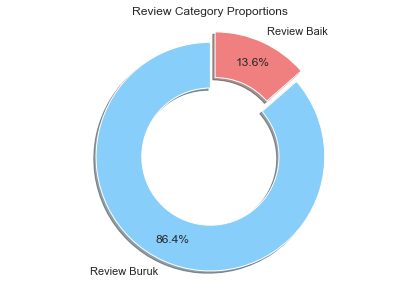

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

## Ekplorasi Emoji Dalam Ulasan

### Sample Ulasan Dengan Emoji

In [ ]:
sample_emoji1 = train.review_text[4777]
sample_emoji2 = train.review_text[7159]

In [ ]:
display(sample_emoji1, sample_emoji2)

'Ga ada jendela😂\n'

'lokasi... pelayanan...fasilitas... 👎🏻'

In [ ]:
demojized1, demojized2 = emoji.demojize(sample_emoji1), emoji.demojize(sample_emoji2)
display(demojized1, demojized2)

'Ga ada jendela:face_with_tears_of_joy:\n'

'lokasi... pelayanan...fasilitas... :thumbs_down_light_skin_tone:'

Di sini terlihat bahwa emoji yang telah dikonversi memiliki pattern sebagai berikut: <font size="3">:[emoji_name]:</font>

Dapat digunakan library regex untuk mengidentifikasi pattern tersebut.

### Melihat ulasan dengan emoji

In [ ]:
# Both functions below will assist in retrieving text containing emojis.

# Function to iterate over all review text (will return text if there is emoji)
def is_emoji(text):
    demojized_txt = emoji.demojize(text)
    res = re.findall(':[a-zA-Z_]+:', demojized_txt)
    if res:
        return text # return original text if emoji is present
    
# Function to return row indexes of emoji reviews
def emoji_indexes(series):
    filtered = series.map(is_emoji).dropna()
    return list(filtered.index)
    

In [ ]:
# Row indexes for reviews that contain emoji
train_emo_ix = emoji_indexes(train.review_text)
test_emo_ix = emoji_indexes(test.review_text)

In [ ]:
# Only reviews that contain emoji
train_emo_only = train.review_text.loc[train_emo_ix]
test_emo_only = test.review_text.loc[test_emo_ix]

In [ ]:
# Change some display settings
# pd.set_option('display.max_colwidth',None)

# Show train text with emojis
train[['review_text']].loc[train_emo_ix].head()

,review_text
99,shower mati deh 😥\nreceptionisep kurang senyum 😏
107,handuknya gak ada . remote AC rusak cuma bisa ...
115,banyak hewan item2 kecil.. jadi bikin kurang n...
117,"kasurnya bunyi, sprei banyak semutnya seperti..."
118,"hotel jadul, dari masuk lobi bau lembab menyen..."


### Ekstraksi Emoji Set (List of unique emojis)

In [ ]:
def unique_emojis(series):
    emojis = [] # list to store all emojis in series
    demojized = series.map(emoji.demojize)
    for text in demojized:
        emojis.extend(re.findall(':[a-z_]+:', text))
    
    emojis = set(emojis) # keep uniques
    emojis = [emoji.emojize(emo) for emo in emojis]
    
    return emojis
    

In [ ]:
train_emo_set = unique_emojis(train_emo_only)
print(f'Count of unique emojis in train: {len(train_emo_set)}')
train_emo_set

Count of unique emojis in train: 73


['😟',
 '😢',
 '😰',
 '🐜',
 '😓',
 '😏',
 '☺',
 '🙏🏻',
 '😬',
 '🙄',
 '🙏',
 '👍🏻',
 '😐',
 '😫',
 '🤦🏻\u200d♂️',
 '❤',
 '🤣',
 '😘',
 '👍',
 '😒',
 '😝',
 '😑',
 '😧',
 '😖',
 '😁',
 '👀',
 '😆',
 '💔',
 '👎',
 '😷',
 '☹️',
 '❤️',
 '🖕',
 '😉',
 '😃',
 '😔',
 '😦',
 '😇',
 '🤔',
 '😤',
 '☺️',
 '😌',
 '😜',
 '🤢',
 '👏',
 '😠',
 '😱',
 '👎🏻',
 '😵',
 '👣',
 '👍🏽',
 '🤗',
 '😨',
 '😕',
 '😲',
 '😂',
 '😥',
 '😅',
 '😡',
 '⭐',
 '😊',
 '😈',
 '😭',
 '😣',
 '😩',
 '💯',
 '👇',
 '😀',
 '😞',
 '🤮',
 '😪',
 '😄',
 '🙁']

In [ ]:
test_emo_set = unique_emojis(test_emo_only)
print(f'Count of unique emojis in test: {len(test_emo_set)}')
test_emo_set

Count of unique emojis in test: 46


['😟',
 '😢',
 '🙄',
 '😰',
 '☺',
 '😏',
 '🤘',
 '🙏',
 '👿',
 '👍🏻',
 '❤',
 '😘',
 '👍',
 '😒',
 '😑',
 '😁',
 '😆',
 '😷',
 '👎',
 '☹️',
 '😇',
 '😉',
 '😔',
 '🤔',
 '☔',
 '😌',
 '👏',
 '👎🏻',
 '♥',
 '😕',
 '😂',
 '😥',
 '😅',
 '😡',
 '⭐',
 '😊',
 '😈',
 '😭',
 '😣',
 '😩',
 '😯',
 '😀',
 '😞',
 '🤮',
 '😪',
 '😄']

In [ ]:
# Does all emojis in test exist in train?
len([_ for emo in test_emo_set if emo in train_emo_set])

41

<font size=3>Dari 46 emoji unik pada data test, hanya 41 emoji yang muncul dalam data train.</font>

### Proporsi Ulasan Dengan Emoji & Distribusi Kelas Emoji Pada Train

### A. Train Data

In [ ]:
# Reuse the is_emoji function from before.
train['emoji'] = train.review_text.map(lambda x:'has emoji' if is_emoji(x) else 'no emoji')
train.head()
            

,review_id,review_text,category,emoji
0,0fc651bfdd38a3b4ba19ef9d0d1e92e3,"Penginapannya rapi, bersih, suasana tenang, pe...",1,no emoji
1,7d8cb2e465c5602e51c1ba8710e8ff16,"wifi tidak sampai kamar, tidak tersedia heater...",0,no emoji
2,1f4447c73e5e1aac462d05b0ecbd5a55,"Lantai kamar mandi kotor, bau, dan seperti sdh...",0,no emoji
3,b9aefbfb0debbfff43f8b268c82b43c0,"Wc jorok.. Kasur tidak dibersihkan,, handuk ti...",0,no emoji
4,e2afef18bd695fae43d4d53b8c547bd4,bocor lagi,0,no emoji


In [ ]:
# Count of emoji rows
has_emoji = (train['emoji']=='has emoji')
print(f'Number of reviews that contain emoji: {sum(has_emoji)}')

Number of reviews that contain emoji: 418


In [ ]:
# Count of categories for reviews that has emoji.
tr_has_emoji_counts = train.emoji.value_counts()
tr_has_emoji_counts

no emoji     14438
has emoji      418
Name: emoji, dtype: int64

<font size=3> Kesimpulan:
- 14438 ulasan pada data train tidak memiliki emoji
- 418 ulasan pada data train memiliki emoji

In [ ]:
# Class distribution of emoji reviews
emoji_classes = train[train.emoji=='has emoji'].category.value_counts()
emoji_classes

0    364
1     54
Name: category, dtype: int64

### B. Test Data 

In [ ]:
# Since test data has no labels, we can only see whether each review has an emoji i.e. no class distribution.
test['emoji'] = test.review_text.map(lambda x:'has emoji' if is_emoji(x) else 'no emoji')
test.head()

,review_id,review_text,emoji
0,7302180ac7160f04a405d8aa7bd6beb8,"Kasur rusak, punggung saya sakit, kasurnya ga ...",no emoji
1,3184c670e170f565c7522eb76a320ba1,gerah,no emoji
2,e33abf6bb5d5a9a77c339043b1725dc8,"tempat ridur atas bawah.. ac nya pararel, tdk ...",no emoji
3,061d388950340070a6ac03fabc9027b0,"ac kurang dingin, tidak ada snack sperti di foto",no emoji
4,e62d87c348674b6c06856964f3ab16b8,Lumayan untuk guest house dengan standart harg...,no emoji


In [ ]:
# Count of categories for reviews that has emoji
ts_has_emoji_counts = test.emoji.value_counts()
ts_has_emoji_counts

no emoji     3623
has emoji      91
Name: emoji, dtype: int64

<font size=3> Kesimpulan:
- 3623 ulasan pada data test tidak memiliki emoji
- 91 ulasan pada data test memiliki emoji

<font size=3> Plot hasil penemuan:

In [ ]:
# plt.style.use('default')

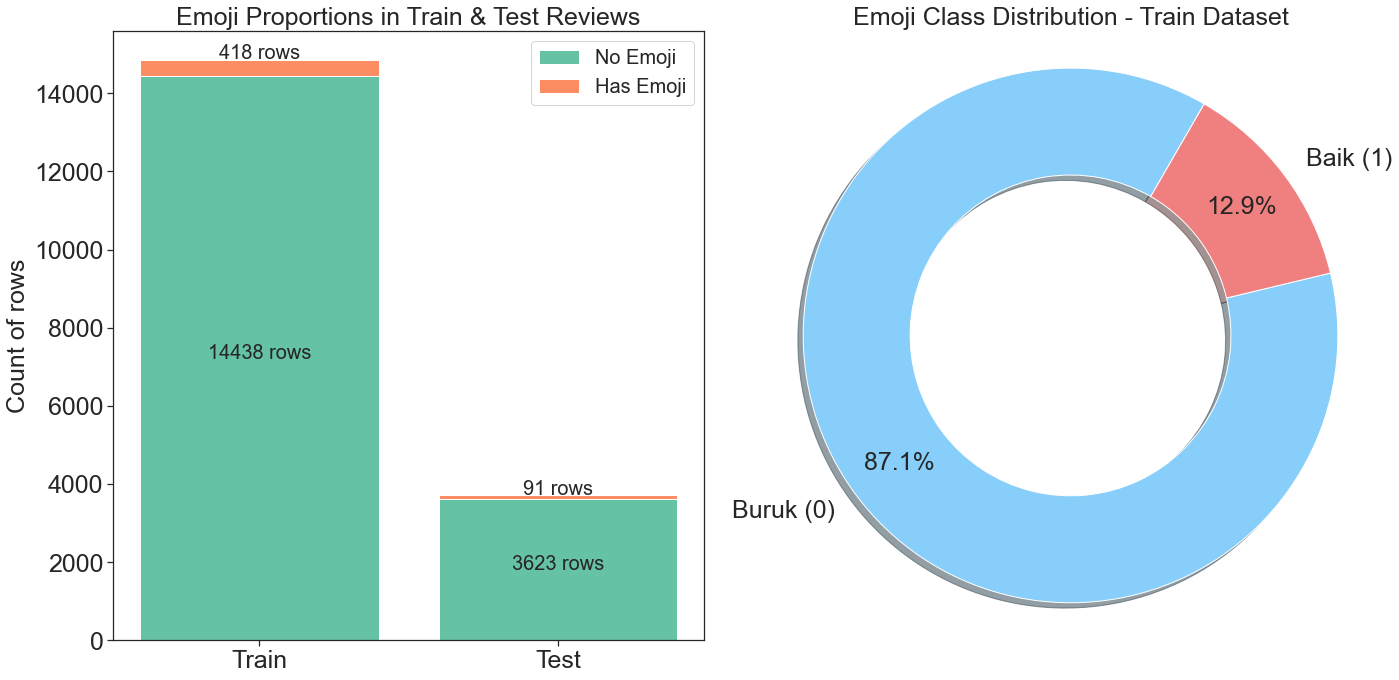

In [ ]:
# Alter a few params
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['font.size'] = 25

# Create axes
f, (ax,ax2) = plt.subplots(1,2,figsize=(20,10))

# Data to be visualized
no_emo = [14438, 3623]
has_emo = [418, 91]
ix = [0,1]
lab = ['Train', 'Test']

# Stacked bar
ax.bar(lab, no_emo, width=0.8, label='No Emoji') # no emo
ax.bar(lab, has_emo, width=0.8, label='Has Emoji', bottom=no_emo) # has emo
ax.set_title('Emoji Proportions in Train & Test Reviews', fontsize=25)
ax.set_ylabel('Count of rows', fontsize=25)
ax.legend(prop={'size':20})

# Text on bar
for i,p in enumerate(ax.patches):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height} rows', (x+width/2, height/2 if i<=1 else y+height*1.05), ha='center', fontsize=20)
    
# Donut chart
sizes, labels = emoji_classes.values, ['Buruk (0)', 'Baik (1)']
donut(sizes,ax2,60,labels, colors=colors, explode=None, shadow=True)
ax2.set_title('Emoji Class Distribution - Train Dataset')
    
# Show plot    
plt.tight_layout()
plt.show()

In [ ]:
del train['emoji']
del test['emoji']

NameError: ignored

## Corpus

<font size=3>Pada bagian ini, akan dibuat sebuah korpus untuk masing-masing ulasan pada train dan test.</font>

In [ ]:
def clean_string(text):
    cleaned = re.sub('[^a-zA-Z]+',' ',text).lower() # exclude numbers
    return cleaned

In [ ]:
def make_corpus(column):
    
    corpus_list = []
    additional_stop = ['yg', 'nya']
    all_stopwords = stopwords.words('indonesian') + additional_stop
    
    for text in column:
        cleaned = clean_string(text)
        cleaned_list = cleaned.split(' ')
        
        # Stem words to shortest form
        stemindo = StemmerFactory().create_stemmer()
        stemmed_list = map(stemindo.stem, cleaned_list)
        
        # Remove stopwords
        stemmed_list = [word for word in cleaned_list if word not in all_stopwords]
        corpus_list.extend(stemmed_list)
        
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one
        
    return corpus

In [ ]:
# Takes a while
train_corpus = make_corpus(train.review_text)
test_corpus = make_corpus(test.review_text)

NameError: ignored

In [ ]:
train_corpus_set = set(train_corpus.split(' '))
test_corpus_set = set(test_corpus.split(' '))

print(f'Count of unique words in train: {len(train_corpus_set)}')
print(f'Count of unique words in test: {len(test_corpus_set)}')

### Visualize Corpus

In [ ]:
nltk.download('punkt') # for freqdist

In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [ ]:
train_freq = word_freq(train_corpus, top=10)
test_freq = word_freq(test_corpus, top=10)

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

sns.barplot(x='word', y='freq', data=train_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')

sns.barplot(x='word', y='freq', data=test_freq, ax=ax2)
ax2.set_title('Word Frequency in Test Data')

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

In [ ]:
# Stopwords
additional_stop = ['nya','yg','ga','gk','tp']
all_stopwords = stopwords.words('indonesian') + additional_stop

In [ ]:
# Cloud for train corpus
wordcloud = WordCloud(stopwords=all_stopwords,max_font_size=50, max_words=100, background_color="white").generate(train_corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# Cloud for test corpus
wordcloud = WordCloud(stopwords=all_stopwords,max_font_size=50, max_words=100, background_color="white").generate(test_corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Ulasan non-alphanumeric

Akan dicari id ulasan yang tidak bersifat alphanumeric.



In [ ]:
# Clear Non-Alphanumeric and lowercase
edatrain = train.copy()
edatest = test.copy()
edatrain['review_text'] = edatrain['review_text'].apply(lambda x : re.sub('[^a-zA-Z0-9]',' ',x).lower())
edatest['review_text'] = edatest['review_text'].apply(lambda x : re.sub('[^a-zA-Z0-9]',' ',x).lower())

In [ ]:
# Pembuatan list kosong untuk menginkorporasi 'review_id' yang berisikan konten non-alphanumeric.
problematic = []

# Pembersihan whitespace dari seluruh record dataset.
antinan = edatrain.copy()
antinan['string'] = antinan['review_text'].apply(lambda x : re.sub('\s','',x))

# Pencarian seluruh 'review_id' yang tidak memiliki apapun di dalam recordnya.
errors = 0
for i in range (0,len(antinan.index)):
    if antinan['string'][i] == '':
        problematic.append(antinan['review_id'][i])
        errors += 1

print('Found ', errors, ' errors!')
problematic

Found  21  errors!


['ae3f2336b8246b6214e325e561488b97',
 'cc059398cf5fd3d110967f0b27fad73f',
 '7c65dbafe1efd03da5356a5e77e19c72',
 '617c6594518e1342b1976829604d1a4c',
 'd4fa1af0924e45e2363e56c14de94e89',
 'a2f3073833374832609071e0b5bcd2bb',
 '0ab8e42b7454ed01e09858437009f817',
 'b9e70aef0ed3986f01c036a60370b008',
 '048091bb5c97447e025a6b4e79cb1e53',
 '606825e4db9876c06153cc923cea9a8a',
 'f5ed27898ab4e134179aeca4d17f621a',
 'a0eefc096248721cbfd5a86921458d28',
 '65a010da47a8d91ae429b8817eff0209',
 '1b2513e42654c096053bb446224af202',
 '35b773e77ae8aef0b3b9c50f9973e495',
 '163adeba41019c0c417918a808fb3fd9',
 '98743941ffce62470ce18de7903e52af',
 '61d384887358af1a3ae849f60abd2194',
 'a3772e8bb6fa5f88e83e543379d36d15',
 '7ecfea6c743491983657e8893e4ddac7',
 'ac195cf5ea17eb1d79b3abcc57cffcd0']

Setelah menemukan id ulasan yang bermasalah, selanjutnya akan ditampilkan ulasan-ulasan tersebut.

In [ ]:
problematicreviews = train[edatrain['review_id'].apply(lambda x : x in problematic)]
problematicreviews

,review_id,review_text,category
952,ae3f2336b8246b6214e325e561488b97,~,0
3193,cc059398cf5fd3d110967f0b27fad73f,👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻👎🏻,0
5286,7c65dbafe1efd03da5356a5e77e19c72,😐,0
5469,617c6594518e1342b1976829604d1a4c,.. ..\n,0
6536,d4fa1af0924e45e2363e56c14de94e89,,0
7031,a2f3073833374832609071e0b5bcd2bb,------,0
8191,0ab8e42b7454ed01e09858437009f817,😔,0
8435,b9e70aef0ed3986f01c036a60370b008,😞,0
8523,048091bb5c97447e025a6b4e79cb1e53,?,0
8552,606825e4db9876c06153cc923cea9a8a,😢,0


## Panjang Ulasan

Cari panjang ulasan dari "train.csv" dan "test.csv" dengan menggunakan tokenization yang akan dilakukan di bawah ini.

In [ ]:
# Tokenization
edatrain['tokenized'] = edatrain['review_text'].apply(lambda x : x.split())
edatest['tokenized'] = edatest['review_text'].apply(lambda x : x.split())

In [ ]:
# Pencarian panjang dari tiap list yang ada pada kolom 'tokenized'
edatrain['length_of_review'] = edatrain['tokenized'].apply(lambda x : len(x))
edatest['length_of_review'] = edatest['tokenized'].apply(lambda x : len(x))

# Menunjukkan kolom 'review_id' serta 'length_of_review'
print(edatrain[['review_id','length_of_review']], '\n', edatest[['review_id','length_of_review']])

                              review_id  length_of_review
0      0fc651bfdd38a3b4ba19ef9d0d1e92e3                29
1      7d8cb2e465c5602e51c1ba8710e8ff16                26
2      1f4447c73e5e1aac462d05b0ecbd5a55                36
3      b9aefbfb0debbfff43f8b268c82b43c0                 8
4      e2afef18bd695fae43d4d53b8c547bd4                 2
...                                 ...               ...
14851  5ed96732e4f1e1e69dfb8669cf507587                 5
14852  b0692bdf4926ee0d58c2d9a0f28b0d62                 3
14853  5217f5f284066f232d7b3c3bbd3cccd2                 9
14854  31ca5a04ccc0dae4eaafc91c9822bede                 4
14855  aadb614310e5ceb79b4c68d14f8dab8a                18

[14856 rows x 2 columns] 
                              review_id  length_of_review
0     7302180ac7160f04a405d8aa7bd6beb8                12
1     3184c670e170f565c7522eb76a320ba1                 1
2     e33abf6bb5d5a9a77c339043b1725dc8                28
3     061d388950340070a6ac03fabc9027b0          

Setelah didapatkan panjang dari tiap ulasan untuk tiap id, maka dapat dilihat karakteristik panjang ulasan untuk kedua dataset yang akan membantu untuk EDA serta pertimbangan konstruksi model.

In [ ]:
# Metrik untuk rekapitulasi terkait panjang ulasan.
maxtrain = max(edatrain['length_of_review'])
avgtrain = sum(edatrain['length_of_review'])/len(edatrain.index)
mintrain = min(edatrain['length_of_review'])
devtrain = np.std(edatrain['length_of_review'])
maxtest = max(edatest['length_of_review'])
avgtest = sum(edatest['length_of_review'])/len(edatest.index)
mintest = min(edatest['length_of_review'])
devtest = np.std(edatest['length_of_review'])

print('Rekapitulasi dari panjang ulasan:\n')
print('- Train -')
print('Max = ', maxtrain, '\nMin = ', mintrain, '\nAverage = ', avgtrain,'\nStdDev = ', devtrain)
print('\n- Test -')
print('Max = ', maxtest, '\nMin = ', mintest, '\nAverage = ', avgtest, '\nStdDev = ', devtest)

Rekapitulasi dari panjang ulasan:

- Train -
Max =  125 
Min =  0 
Average =  16.63031771674744 
StdDev =  14.374959213962784

- Test -
Max =  134 
Min =  0 
Average =  16.274367259019925 
StdDev =  14.19017897201063


Untuk bisa lebih memahami distribusi dari panjang ulasan yang terdapat di dalam kedua dataset, dilakukan plotting dalam bentuk histogram.

In [ ]:
# Penggunaan library plotly untuk menggambarkan Histogram frekuensi dari panjang ulasan.
fig1 = px.histogram(x = edatrain['length_of_review'], nbins = 200)
fig2 = px.histogram(x = edatest['length_of_review'], nbins = 200)
fig1.show()
fig2.show()

# Data Preprocessing

<font size=3>Tahap ini akan meliputi dua versi pemrosesan data, yaitu preprocessing v1 dan preprocessing v2. Namun, pertama data train akan displit menjadi train_set dan val_set dengan rasio 0.8/0.2 dan test_set. Ketiga dataframe tersebut akan melalui preprocessing v1 dan v2. </font>

In [ ]:
# train val split
train_set, val_set = train_test_split(train, test_size=0.2, stratify=train.category, random_state=1)
test_set = test.copy()

NameError: ignored

## Preprocessing V1

In [ ]:
# Functions used in preprocessing v1.

# 1. Clean 
def clean_review(text):

    # demojize first
    cleaned = emoji.demojize(text)
    
    # double whitespace to single
    cleaned = re.sub('[ ]+',' ',cleaned)
    
    return cleaned

# 2. Full clean
def full_clean(text):

    # demojize first
    text = emoji.demojize(text)
    
    # clean
    cleaned = re.sub('[^a-zA-Z0-9]+',' ',text).lower() # clean everything (emoji inc.)
    
    # remove 2 letter words
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    cleaned = re.sub(shortword, '', cleaned)
    
    # double whitespace to single
    cleaned = re.sub('[ ]+',' ',cleaned)
    
    return cleaned

# 3. Func to find 'en' in set of words
def find_en(row, ignore_indexes):
    result = 'no en'
    
    if re.findall(':[a-zA-Z_]+:', row.review_text):
        result = 'has en'
    elif row.name in ignore_indexes:
        result = 'no en'
    elif detect(row.review_text) == 'en':
        result = 'has en'
    else:
        result = 'no en'
        
    return result

# 4. remove punc from emoji
def remove_emo_punc(text):
    text = re.sub('[:_-]+',' ',text)
    return text

# 5. Google Translate
translator = google_translator() 
def trans_to_id(text):
    res = translator.translate(text,lang_src='en',lang_tgt='id')  
    return res

In [ ]:
def preprocess_v1(df):
    df_pp = df.copy()
    
    # demojize all reviews (clean_text function)
    df_pp.review_text = df_pp.review_text.map(clean_review)
    
    # find abnormal rows (full_clean function)
    df_fcleaned = df_pp.review_text.map(full_clean)
    ## indexes of garbage rows (reviews with no text, only punctuation, etc.)
    df_empty_after_cleaned_ix = df_fcleaned.loc[(df_fcleaned=='')|(df_fcleaned==' ')].index
    
    # locate reviews that has english (find_en function)
    df_en_res = df_pp.apply(find_en, args=(df_empty_after_cleaned_ix,), axis=1)
    ## create mask from results
    df_has_en_mask = (df_en_res == 'has en')
    ### final english indexes
    df_has_en_ix = [i for i,j in enumerate(df_has_en_mask) if j]
    
    # remove punctuation from emoji (remove_emo_punc function)
    df_pp.review_text.loc[df_has_en_mask] = df_pp.review_text.loc[df_has_en_mask].map(remove_emo_punc)
    
    # translate rows that has english (trans_to_id)
    df_en_translated = df_pp.review_text.loc[df_has_en_mask].map(trans_to_id)
    
    # combine translated rows with initial dataframe
    df_pp.review_text.loc[df_has_en_ix] = df_en_translated
    
    return df_pp
    

In [ ]:
train_v1, val_v1, test_v1,  = preprocess_v1(train_set), preprocess_v1(val_set), preprocess_v1(test_set)

NameError: ignored

In [ ]:
# export to csv
train_v1.drop('review_id', axis=1).to_csv('train_v1.csv', index=False)
val_v1.drop('review_id', axis=1).to_csv('val_v1.csv', index=False)

# add empty category column to test_v1 b4 exporting
test_v1['category'] = np.zeros(len(test_v1))
test_v1.drop('review_id', axis=1).to_csv('test_v1.csv', index=False)



## Preprocessing V2

In [ ]:
# Functions used in preprocessing v2. (mostly the same but some slightly changed)

# 1. Clean from emoji so lang.detect can determine eng rows
def clean_review(text):

    # demojize first
    cleaned = emoji.demojize(text)
    cleaned = re.sub(':[A-Za-z_]+:', '', cleaned) # delete emot
    
    # double whitespace to single
    cleaned = re.sub('[ ]+',' ',cleaned)
    
    return cleaned

# 2. Same function as full_clean

# 3. func to find 'en' in set of words
def find_en(row, ignore_indexes):
    result = 'no en'

    if row.name in ignore_indexes:
        result = 'no en'
    elif detect(row.review_text) == 'en':
        result = 'has en'
    else:
        result = 'no en'
        
    return result

# 4. Google Translate
translator = google_translator() 
def trans_to_id(text):
    res = translator.translate(text,lang_src='en',lang_tgt='id')  
    return res

In [ ]:
def preprocess_v2(df):
    df_pp = df.copy()
    
    # demojize all reviews (clean_text function)
    df_pp.review_text = df_pp.review_text.map(clean_review)
    
    # find abnormal rows (full_clean function)
    df_fcleaned = df_pp.review_text.map(full_clean)
    ## indexes of garbage rows (reviews with no text, only punctuation, etc.)
    df_empty_after_cleaned_ix = df_fcleaned.loc[(df_fcleaned=='')|(df_fcleaned==' ')].index
    
    # locate reviews that has english (find_en function)
    df_en_res = df_pp.apply(find_en, args=(df_empty_after_cleaned_ix,), axis=1)
    ## create mask from results
    df_has_en_mask = (df_en_res == 'has en')
    ### final english indexes
    df_has_en_ix = [i for i,j in enumerate(df_has_en_mask) if j]
    
    # translate rows that has english (trans_to_id)
    df_en_translated = df_pp.review_text.loc[df_has_en_mask].map(trans_to_id)
    
    # combine translated rows with initial dataframe
    df_pp.review_text.loc[df_has_en_ix] = df_en_translated
    
    return df_pp

In [ ]:
train_v2, val_v2, test_v2  = preprocess_v2(train_set), preprocess_v2(val_set), preprocess_v2(test_set)

NameError: ignored

In [ ]:
# export to csv
train_v2.drop('review_id', axis=1).to_csv('train_v2.csv', index=False)
val_v2.drop('review_id', axis=1).to_csv('val_v2.csv', index=False)

# add empty category column to test_v1 b4 exporting
test_v2['category'] = np.zeros(len(test_v2))
test_v2.drop('review_id', axis=1).to_csv('test_v2.csv', index=False)


# Modelling
Finetuning dilakukan 3x, yaitu pada dataset original, dataset preprocessing V1, dataset preprocessing V2

## Finetuning IndoBERT Dataset Original


In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.5f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

### Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS # 2 labels

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config)

In [ ]:
# Struktur model
model

In [ ]:
# Hitung jumlah parameter modal
count_param(model)

### Persiapan Dataset

In [ ]:
# export to csv
train_set.drop('review_id', axis=1).to_csv('train_ori.csv', index=False)
val_set.drop('review_id', axis=1).to_csv('val_ori.csv', index=False)

# add empty category column to test_v1 b4 exporting
test_set['category'] = np.zeros(len(test_v1))
test_set.drop('review_id', axis=1).to_csv('test_ori.csv', index=False)

In [ ]:
train_dataset_path = '/content/train_ori.csv'
valid_dataset_path = '/content/val_ori.csv'
test_dataset_path = '/content/test_ori.csv'

In [ ]:
#fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

### Uji coba pre-trained model

In [ ]:
text = 'Kamarnya nyaman, bersih, pelayanannya bagus.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

### Finetuning IndoBERT

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
# Train
n_epochs = 3
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    

### Download Hasil Prediksi Validation Set

In [ ]:
# Hasil Validasi
val_df = pd.read_csv(valid_dataset_path)
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result original.csv', index=False)

### Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

# Simpan prediksi
df = pd.read_csv('sample_submission.csv')
df['category'] = pred
df.to_csv('sub original.csv', index=False)

print(df)

## Finetuning IndoBERT Dataset Preprocessing V1


In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.5f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

### Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS # 2 labels

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config)

In [ ]:
# Struktur model
model

In [ ]:
# Hitung jumlah parameter modal
count_param(model)

### Persiapan Dataset

In [ ]:
train_dataset_path = '/content/train_v1.csv'
valid_dataset_path = '/content/val_v1.csv'
test_dataset_path = '/content/test_v1.csv'

In [ ]:
#fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

### Uji coba pre-trained model

In [ ]:
text = 'Kamarnya nyaman, bersih, pelayanannya bagus.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

### Finetuning IndoBERT

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
# Train
n_epochs = 3
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    

### Download Hasil Prediksi Validation Set

In [ ]:
# Hasil Validasi
val_df = pd.read_csv(valid_dataset_path)
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result v1.csv', index=False)

### Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

# Simpan prediksi
df = pd.read_csv('sample_submission.csv')
df['category'] = pred
df.to_csv('sub v1.csv', index=False)

print(df)

## Finetuning IndoBERT Dataset Preprocessing V2


In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.5f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

### Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-large-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-large-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS # 2 labels

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-large-p1', config=config)

In [ ]:
# Struktur model
model

In [ ]:
# Hitung jumlah parameter modal
count_param(model)

### Persiapan Dataset

In [ ]:
train_dataset_path = '/content/train_v2.csv'
valid_dataset_path = '/content/val_v2.csv'
test_dataset_path = '/content/test_v2.csv'

In [ ]:
#fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=16, num_workers=16, shuffle=False)

In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

### Uji coba pre-trained model

In [ ]:
text = 'Kamarnya nyaman, bersih, pelayanannya bagus.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

### Finetuning IndoBERT

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [ ]:
# Train
n_epochs = 3
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    

### Download Hasil Prediksi Validation Set

In [ ]:
# Hasil Validasi
val_df = pd.read_csv(valid_dataset_path)
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result v2.csv', index=False)

### Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

# Simpan prediksi
df = pd.read_csv('sample_submission.csv')
df['category'] = pred
df.to_csv('sub v2.csv', index=False)

print(df)

## Ensemble Model (Blending)

### Persiapan Dataset

In [ ]:
val_1 = pd.read_csv('val result original.csv')
val_2 = pd.read_csv('val result v1.csv')
val_3 = pd.read_csv('val result v2.csv')

sub_1 = pd.read_csv('sub original.csv')
sub_2 = pd.read_csv('sub v1.csv')
sub_3 = pd.read_csv('sub v2.csv')

In [ ]:
# Cek apa label sama semua
any(val_1['category'] != val_2['category'])
# any(val_1['category'] != val_3['category'])
# any(val_2['category'] != val_3['category'])

In [ ]:
# Gabungkan data
val_comb = pd.concat([val_1['pred'], val_2['pred'],val_3['pred']], axis=1)
val_comb.columns = ['pred1','pred2', 'pred3']

sub_comb = pd.concat([sub_1['category'], sub_2['category'], sub_3['category']], axis=1)
sub_comb.columns = ['pred1','pred2', 'pred3']

sub_comb

In [ ]:
y_val = val_1['category']

### Blending

In [ ]:
blend = XGBClassifier(objective='binary:logistic', eval_metric='error', seed=27,
                      use_label_encoder=False)
blend.fit(val_comb, y_val)

# Validation

## Cross Validation

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=27)

acc = cross_val_score(blend, val_comb, y_val, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.5f (%.5f)' % (np.mean(acc), np.std(acc)))

f1 = cross_val_score(blend, val_comb, y_val, scoring='f1_macro', cv=cv, n_jobs=-1)
print('F1 macro: %.5f (%.5f)' % (np.mean(f1), np.std(f1)))

In [ ]:
cv = KFold(n_splits=5, random_state=27, shuffle=True)
val_pred = cross_val_predict(blend, val_comb, y_val, cv=cv)
conf_mat = confusion_matrix(y_val, val_pred)
plt.figure(figsize=(10,6))
sns.heatmap(conf_mat, annot=True,annot_kws={"size": 24})

## Prediksi Test Set Final

In [ ]:
blend_pred = model.predict(sub_comb)
pd.Series(blend_pred).value_counts()

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['category'] = blend_pred
submission.to_csv('submission ELSIX.csv', index=False)